In [1]:
import os
from itertools import compress
import re
import string
import numpy as np

from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

## TODO:
- Apply the evaluation pipeline to multiple topic models
- Apply the evaluation pipeline to different doc embeddings
- Apply the evaluation pipeline to more datasets


# Loading the data

In [2]:
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
X, y = newsgroups_data.data, newsgroups_data.target

# Cleaning the data

In [5]:
re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')


def clean_text(text):        
    text = text.lower()
    text = text.strip()
    text = re.sub(re_url, '', text)
    text = re.sub(re_email, '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'(\d+)', ' ', text)
    text = re.sub(r'(\s+)', ' ', text)  
    return text


# Clean text
X_clean = list(map(clean_text, X))
print(len(X_clean))

# Remove blank documents
doc_ids = [len(doc) > 2 for doc in X_clean]
X_clean = list(compress(X_clean, doc_ids))
y_clean = list(compress(y, doc_ids))
print(len(X_clean))

# Remove documents with 4 words or less
doc_ids = [len(doc.split(' ')) > 4 for doc in X_clean]
X_clean = list(compress(X_clean, doc_ids))
y_clean = list(compress(y_clean, doc_ids))
print(len(X_clean))

# Remove outliers (in embedding space)
doc_ids = ['the most current orbital' not in doc for doc in X_clean]
X_clean = list(compress(X_clean, doc_ids))
y_clean = list(compress(y_clean, doc_ids))
print(len(X_clean))

18846
18307
18131
18125


# Creating/loading embeddings

In [6]:
embeddings_file = '../../outputs/experiments/embeddings.npy'
# Check whether there are saved embeddings in disk
if os.path.isfile(embeddings_file):
    # Load the SBERT embeddings from disk
    embeddings = np.load(embeddings_file)
else:
    # Create SBERT embeddings
    embeddings = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v4').encode(X_clean, show_progress_bar=True)
    # Save the SBERT embeddings to disk
    np.save(embeddings_file, embeddings)

Batches: 100%|██████████| 567/567 [02:13<00:00,  4.26it/s]


# UMAP 2-dimensional map

In [7]:
# Initialize UMAP
umap_model = UMAP(
    n_neighbors=30, 
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=1
)

# Reduce to 2 dimensions
umap_emb = umap_model.fit_transform(embeddings)

# Topic Modeling

In [44]:
# Setting hyperparameters
umap_model = UMAP(
    n_neighbors=30, 
    n_components=10,
    min_dist=0.0,
    metric='euclidean',
    random_state=1
)
hdbscan_model = HDBSCAN(
    min_cluster_size=100, 
    metric='euclidean',
    prediction_data=True
)
vectorizer_model = CountVectorizer(
    ngram_range=(1, 1),
    stop_words="english"
)
n_gram_range = (1, 1)

# Declaring the model
model = BERTopic(
    n_gram_range=n_gram_range,
    nr_topics=20,
    embedding_model="sentence-transformers/msmarco-distilbert-base-v4",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model
)

# Train the BERTopic model
doc_topics, _ = model.fit_transform(X_clean, embeddings=embeddings)
set(doc_topics)

# Model evaluation

## K-NN classifier accuracy using UMAP embeddings

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(10)

avg_accuracies = {}
std_accuracies = {}
for k in [10, 20, 40, 80, 160]:
    accuracies = []
    for train_ix, test_ix in skf.split(umap_emb, y_clean):
        # Get train and test samples
        X_train, X_test = umap_emb[train_ix], umap_emb[test_ix]
        y_train, y_test = np.array(y_clean)[train_ix], np.array(y_clean)[test_ix]

        # Initialize the KNN classifier
        knn = KNeighborsClassifier(
            n_neighbors=k,
            weights='uniform',
            algorithm='brute',
            metric='cosine',
            n_jobs=-1
        )

        # Get KNN classifier predictions
        knn.fit(X_train, y_train)
        y_test_pred = knn.predict(X_test)

        # Compute accuracy on test split
        accuracies.append(accuracy_score(y_test, y_test_pred))
    avg_accuracies[k] = np.mean(accuracies)
    std_accuracies[k] = np.std(accuracies)

print(avg_accuracies)
print(std_accuracies)

{10: 0.3700970364877649, 20: 0.3919451618127115, 40: 0.40463503103048987, 80: 0.408607262486165, 160: 0.4095458480510515}
{10: 0.007765619973711913, 20: 0.006050765000267512, 40: 0.007308046758764071, 80: 0.00642010195040999, 160: 0.007456657022873984}


## Agreement between true labels and topics

In [40]:
from sklearn.metrics import normalized_mutual_info_score

# 0 value indicates two independent label assignments
# 1 value indicates two agreeable label assignments
print('NMI with -1 labels: ', normalized_mutual_info_score(y_clean, doc_topics))
doc_ids = [top != -1 for top in doc_topics]
print('NMI without -1 labels: ', normalized_mutual_info_score(list(compress(y_clean, doc_ids)), list(compress(doc_topics, doc_ids))))

NMI with -1 labels:  0.47172124773625146
NMI without -1 labels:  0.5974557050538678


## Topic Coherence and Diversity

In [47]:
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO
from octis.evaluation_metrics.coherence_metrics import Coherence, WECoherencePairwise


def topic_evaluation(model_output, texts):
    """
    Provide a topic model output and get the score on several metrics.
    """
    output = {}

    # Topic Diversity
    metric = TopicDiversity(topk=10)
    output['topic_diversity'] = metric.score(model_output)

    # Topic Diversity - inverted RBO
    metric = InvertedRBO(topk=10)
    output['inverted_rbo'] = metric.score(model_output)

    # Topic Coherence - internal
    metric = Coherence(texts=texts, topk=10, measure='c_v')
    output['topic_coherence_c_v'] = metric.score(model_output)

    # Topic Coherence - external
    metric = WECoherencePairwise(topk=10)
    output['topic_coherence_we_coherence_pairwise'] = metric.score(model_output)

    return output

In [51]:
# Get topic diversity and topic coherence metrics
model_output = {
    'topics': [[word[0] for word in values] for _, values in model.topics.items()],
    'topic-word-matrix': model.c_tf_idf,
    'topic-document-matrix': np.array(doc_topics)
}
topic_evaluation(model_output, list(map(lambda x: x.split(' '), X_clean)))

{'topic_diversity': 0.9533333333333334,
 'inverted_rbo': 0.9949792255716327,
 'topic_coherence_c_v': 0.7443274073428415,
 'topic_coherence_we_coherence_pairwise': 0.2964163}

## UMAP plot: Original labels vs Topics

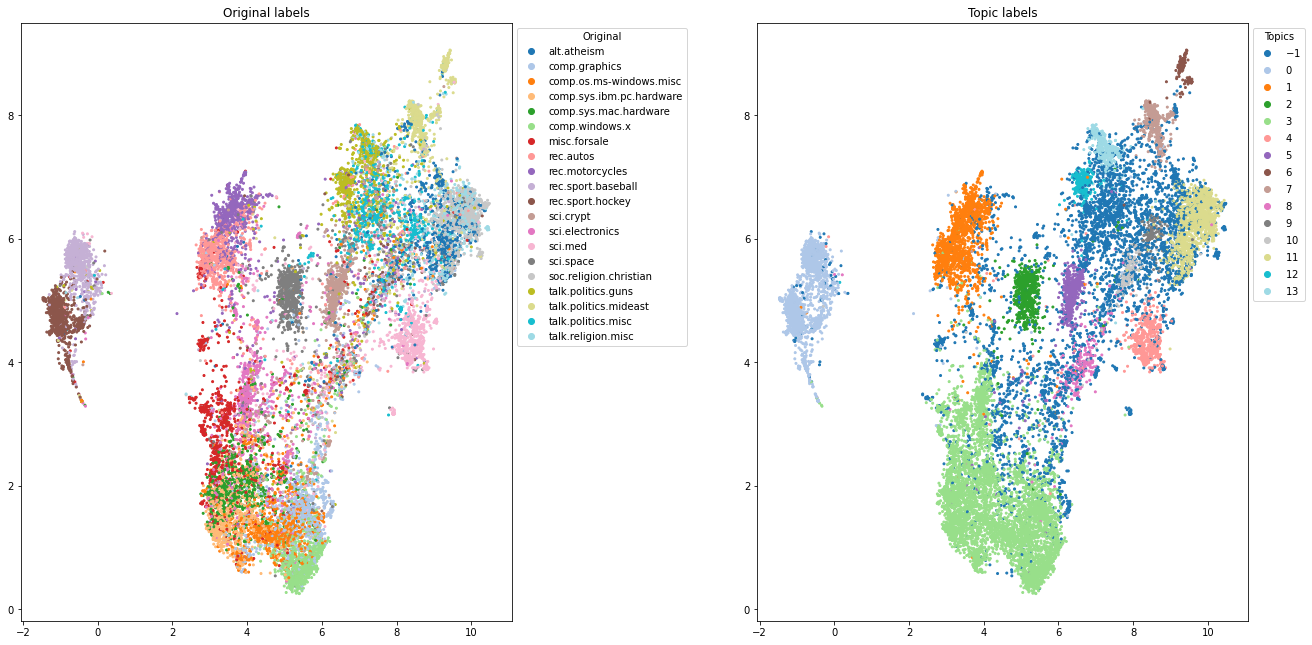

In [46]:
# Plot the 2D UMAP projection with the topic labels vs original labels

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 11))
plt.subplots_adjust(wspace=0.5)

# Set axis 1 - Original labels
ax1.set_title("Original labels")
scatter = ax1.scatter(umap_emb[:, 0], umap_emb[:, 1], s=4, c=y_clean, cmap='tab20')
ax1.legend(scatter.legend_elements(num=len(set(y_clean)))[0], newsgroups_data.target_names, title="Original",
    bbox_to_anchor=(1,1), loc="upper left")

# Set axis 2 - Topic labels
ax2.set_title("Topic labels")
scatter = ax2.scatter(umap_emb[:, 0], umap_emb[:, 1], s=4, c=doc_topics, cmap='tab20')
ax2.legend(*scatter.legend_elements(num=len(set(doc_topics))), title="Topics",
    bbox_to_anchor=(1,1), loc="upper left")

fig.show()